In [2]:
import os
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
from sklearn.metrics import accuracy_score, balanced_accuracy_score, make_scorer
from sklearn.model_selection import StratifiedKFold, cross_val_score
from tqdm import tqdm

from NEExT import NEExT
from NEExT.builders import EmbeddingBuilder
from NEExT.collections import EgonetCollection
from NEExT.features import NodeFeatures, StructuralNodeFeatures
from NEExT.io import GraphIO
from NEExT.ml_models import MLModels, OutlierDataset, OutlierDetector

%reload_ext autoreload
%autoreload 2

In [3]:
def semi_supervised_set(features_df, col="is_outlier", hide_frac={0: 0.1, 1: 0.1}, seed=42):
    _features_df = features_df.copy()
    np.random.seed(seed)

    for _cls, frac in hide_frac.items():
        mask = _features_df[col] == _cls
        drop_indices = np.random.choice(_features_df[mask].index, size=int(len(_features_df[mask]) * frac), replace=False)
        _features_df.loc[drop_indices, col] = -1

    return _features_df


def initialize_graph(graph_data, frac):
    edges_df = pd.read_csv(graph_data["edge_file_path"])
    mapping_df = pd.read_csv(graph_data["node_graph_mapping_file_path"])
    features_df = pd.read_csv(graph_data["features_file_path"])

    ground_truth_df = features_df.copy()
    features_df = semi_supervised_set(ground_truth_df, hide_frac={0: frac[0], 1: frac[1]})
    ground_truth_df = (
        ground_truth_df.rename(columns={"node_id": "graph_id"})[["graph_id", "is_outlier"]].sort_values("graph_id").reset_index(drop=True)
    )
    return edges_df, mapping_df, features_df, ground_truth_df


def build_features(subgraph_collection, feature_vector_length, feature_list):
    structural_node_features = StructuralNodeFeatures(
        graph_collection=subgraph_collection,
        feature_list=["all"],
        feature_vector_length=feature_vector_length,
        n_jobs=8,
        show_progress=False,
    )
    node_features = NodeFeatures(
        subgraph_collection,
        feature_list=feature_list,
        show_progress=False,
    )
    structural_features = structural_node_features.compute()
    features = node_features.compute()
    return structural_features, features


def build_embeddings(subgraph_collection, structural_features, features, strategy, structural_embedding_dimension, feature_embedding_dimension):
    emb_builder = EmbeddingBuilder(
        subgraph_collection,
        strategy=strategy,
        structural_features=structural_features,
        features=features,
    )
    embeddings = emb_builder.compute(structural_embedding_dimension, feature_embedding_dimension)
    return embeddings

In [4]:
def build_model(strategy, structural_embedding_dimension, feature_embedding_dimension, top_k, threshold):
    embeddings = build_embeddings(
        subgraph_collection,
        structural_features,
        features,
        strategy=strategy,
        structural_embedding_dimension=structural_embedding_dimension,
        feature_embedding_dimension=feature_embedding_dimension,
    )
    dataset = OutlierDataset(subgraph_collection, embeddings, standardize=False)
    detector = OutlierDetector(top_k=top_k, threshold=threshold)
    return dataset, detector


def objective(trial: optuna.Trial):
    params = dict(
        strategy=trial.suggest_categorical(
            "strategy",
            ["separate_embedding", "combined_embedding", "structural_embedding", "merge_egonet_node_features", "only_egonet_node_features"],
        ),
        structural_embedding_dimension=trial.suggest_int("structural_embedding_dimension", 1, 20),
        feature_embedding_dimension=trial.suggest_int("feature_embedding_dimension", 1, 20),
        top_k=trial.suggest_int("top_k", 1, 50),
        threshold=trial.suggest_float("threshold", 0.0, 1.0, step=0.02),
    )

    dataset, detector = build_model(**params)

    bal_accuracy = cross_val_score(
        detector,
        dataset.X_labeled,
        dataset.y_labeled,
        cv=StratifiedKFold(5),
        n_jobs=-1,
        scoring=make_scorer(balanced_accuracy_score),
    )
    return bal_accuracy.mean()


def score_unlabeled_gt(build_model, ground_truth_df, study):
    dataset, detector = build_model(**study.best_trial.params)
    detector.fit(dataset.X_labeled, dataset.y_labeled)

    out = detector.predict_full_df(dataset.unlabeled_graphs, dataset.X_unlabeled)
    out_unlab = out.merge(ground_truth_df[ground_truth_df["graph_id"].isin(out["graph_id"])]).sort_values("is_outlier", ascending=False)
    bl_acc = balanced_accuracy_score(out_unlab["is_outlier"], out_unlab["pred"])
    return bl_acc

In [ ]:
graph_io = GraphIO()
graphs_data = [
    dict(
        name="ABCDO",
        edge_file_path="../data/ABCDO-full/edges.csv",
        node_graph_mapping_file_path="../data/ABCDO-full/graph_mapping.csv",
        features_file_path="../data/ABCDO-full/features.csv",
        target="is_outlier",
        skip_features=["community_id"],
        feature_list=["random_community_feature"],
    )
]

f = np.linspace(0.1, 0.9, 5)
fractions = list(product(f, f))

# fractions = [(0.1, 0.1), (0.5, 0.5)]
# fractions = [(0.1, 0.1)]


results = []

for graph_data in graphs_data:
    for frac in fractions:
        print(frac, graph_data)
        edges_df, mapping_df, features_df, ground_truth_df = initialize_graph(graph_data, frac)
        graph_collection = graph_io.load_from_dfs(
            edges_df=edges_df,
            node_graph_df=mapping_df,
            node_features_df=features_df,
            graph_type="igraph",
        )
        subgraph_collection = EgonetCollection()
        subgraph_collection.create_egonets_from_graphs(
            graph_collection=graph_collection,
            egonet_target=graph_data["target"],
            egonet_algorithm="k_hop_egonet",
            skip_features=graph_data["skip_features"],
            max_hop_length=1,
            # n_iterations=n_iterations,
            # resolution=resolution,
        )
        structural_features, features = build_features(subgraph_collection, feature_vector_length=6, feature_list=graph_data["feature_list"])
        
        study = optuna.create_study(direction="maximize")
        study.optimize(objective, n_trials=50, n_jobs=5)

        info_dict = study.best_trial.params.copy()
        info_dict["dataset"] = graph_data["name"]
        info_dict["num_nodes"] = len(ground_truth_df)
        info_dict["fraction_outliers"] = len(ground_truth_df.query("is_outlier==1")) / len(ground_truth_df)
        info_dict["frac_0"] = frac[0]
        info_dict["frac_1"] = frac[1]
        info_dict["score"] = study.best_trial.values[0]
        info_dict["param_dict"] = study.best_trial.params
        info_dict["score_unlabeled"] = score_unlabeled_gt(build_model, ground_truth_df, study)

        results.append(info_dict)

results = pd.DataFrame(results)

<Axes: xlabel='frac_1', ylabel='frac_0'>

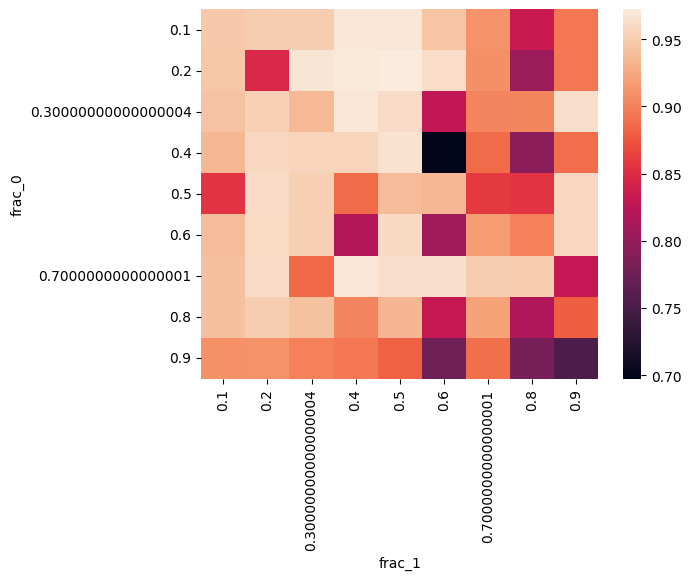

In [ ]:
import seaborn as sns

sns.heatmap(results.pivot(index="frac_0", columns="frac_1", values="score"))

<Axes: xlabel='frac_1', ylabel='frac_0'>

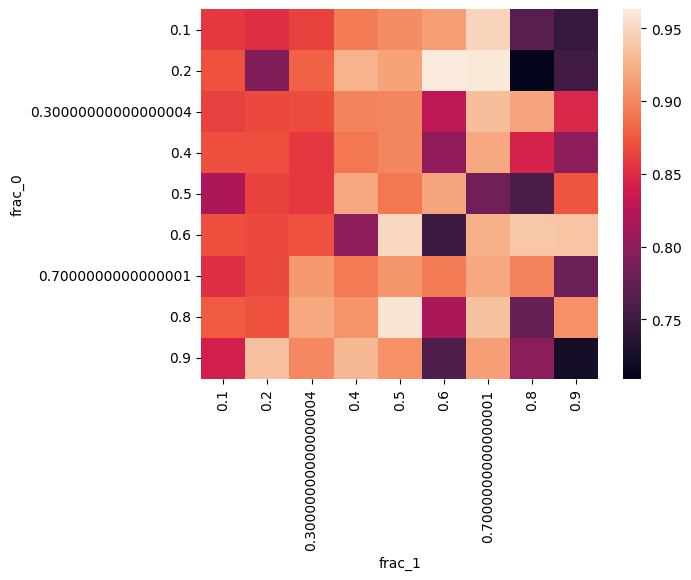

In [ ]:
sns.heatmap(results.pivot(index="frac_0", columns="frac_1", values="score_unlabeled"))